<a href="https://colab.research.google.com/github/KatieMears628/death-classification/blob/main/Copy_of_4Final_Project_Working_Document.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ADS 502 Final Project - Death Classification**
### Team 5 - Katie Mears, Marvin Moran, Claire Bentzen

## 1. Introduction

##### Load Packages

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# !pip install prince
import prince
from scipy.stats import chi2_contingency
import networkx as nx
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout
import tensorflow as tf
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve


In [7]:
import warnings
warnings.filterwarnings('ignore')

##### Read and Examine Dataset

In [8]:
# Read in 2015_data.csv
death_data = pd.read_csv('/content/2015_data.csv')

# Display the first few rows of the data
print(death_data.head())

   resident_status  education_1989_revision  education_2003_revision  \
0                1                      NaN                      3.0   
1                1                      NaN                      6.0   
2                1                      NaN                      3.0   
3                1                      NaN                      3.0   
4                1                      NaN                      5.0   

   education_reporting_flag  month_of_death sex  detail_age_type  detail_age  \
0                         1               1   M                1          84   
1                         1               1   M                1          70   
2                         1               1   F                1          91   
3                         1               1   F                1          40   
4                         1               1   F                1          89   

   age_substitution_flag  age_recode_52  ...  record_condition_18  \
0                

In [9]:
# Print shape of data
death_data.shape

(27477, 77)

In [10]:
# Print Column Titles in Original Data Set
column_titles = death_data.columns
print(column_titles)

Index(['resident_status', 'education_1989_revision', 'education_2003_revision',
       'education_reporting_flag', 'month_of_death', 'sex', 'detail_age_type',
       'detail_age', 'age_substitution_flag', 'age_recode_52', 'age_recode_27',
       'age_recode_12', 'infant_age_recode_22',
       'place_of_death_and_decedents_status', 'marital_status',
       'day_of_week_of_death', 'current_data_year', 'injury_at_work',
       'manner_of_death', 'method_of_disposition', 'autopsy', 'activity_code',
       'place_of_injury_for_causes_w00_y34_except_y06_and_y07_',
       'icd_code_10th_revision', '358_cause_recode', '113_cause_recode',
       '130_infant_cause_recode', '39_cause_recode',
       'number_of_entity_axis_conditions', 'entity_condition_1',
       'entity_condition_2', 'entity_condition_3', 'entity_condition_4',
       'entity_condition_5', 'entity_condition_6', 'entity_condition_7',
       'entity_condition_8', 'entity_condition_9', 'entity_condition_10',
       'entity_condition

In [11]:
# Isolate the Desired Columns
desired_columns = ['education_2003_revision', 'month_of_death', 'sex', 'place_of_death_and_decedents_status',
                   'marital_status', 'day_of_week_of_death', 'injury_at_work', 'manner_of_death', 'method_of_disposition',
                   'autopsy', 'race','detail_age']
new_death = death_data[desired_columns]

# List of column names to convert to categorical
categorical_columns = ['education_2003_revision', 'month_of_death', 'sex', 'place_of_death_and_decedents_status',
                   'marital_status', 'day_of_week_of_death', 'injury_at_work', 'manner_of_death',
                   'method_of_disposition', 'autopsy', 'race']

# Convert the selected columns to categorical
new_death[categorical_columns] = new_death[categorical_columns].astype('category')

In [12]:
# Data Description of original data set with selected columns (2015_data.csv)
data_description_all = new_death.describe(include='all')
print(data_description_all)

        education_2003_revision  month_of_death    sex  \
count                    4193.0         27477.0  27477   
unique                      9.0            12.0      2   
top                         3.0             1.0      M   
freq                     1683.0          5230.0  14216   
mean                        NaN             NaN    NaN   
std                         NaN             NaN    NaN   
min                         NaN             NaN    NaN   
25%                         NaN             NaN    NaN   
50%                         NaN             NaN    NaN   
75%                         NaN             NaN    NaN   
max                         NaN             NaN    NaN   

        place_of_death_and_decedents_status marital_status  \
count                               27476.0          27476   
unique                                  7.0              5   
top                                     4.0              M   
freq                                10312.0          10

##### Convert response variable to only 2 categories

In [13]:
# Convert manner_of_death to homicide or not homicide
new_death['manner_of_death'] = new_death['manner_of_death'].replace([1, 2, 4, 5, 6, 7, None],0)
new_death['manner_of_death'] = new_death['manner_of_death'].replace([3],1)

## 2. Exploratory Data Analysis

In [14]:
# Get the data types for all columns
data_types = new_death.dtypes

print(data_types)

education_2003_revision                category
month_of_death                         category
sex                                    category
place_of_death_and_decedents_status    category
marital_status                         category
day_of_week_of_death                   category
injury_at_work                         category
manner_of_death                        category
method_of_disposition                  category
autopsy                                category
race                                   category
detail_age                                int64
dtype: object


#### 2.1 Categorical Data Analysis

##### 2.1.1 education_2003_revision

education_2003_revision Frequency:
3.0    1683
4.0     669
1.0     431
2.0     409
6.0     389
5.0     270
7.0     149
9.0     139
8.0      54
Name: education_2003_revision, dtype: int64


<Axes: xlabel='education_2003_revision'>

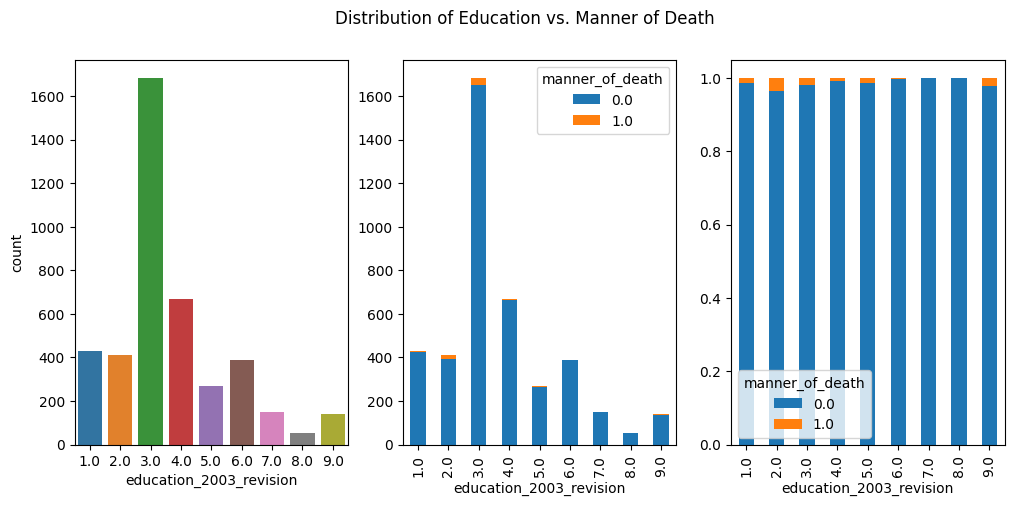

In [15]:
# Value Counts
education_counts = new_death['education_2003_revision'].value_counts()
print("education_2003_revision Frequency:")
print(education_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Education vs. Manner of Death")

# Plot Counts
sns.countplot(x="education_2003_revision", data=new_death, ax=axs[0])

# Plot Counts with Overlay
crosstab_education = pd.crosstab(new_death['education_2003_revision'], new_death['manner_of_death'])
crosstab_education.plot(kind='bar', ax=axs[1], stacked = True)

# Plot Counts with Overlay and Normalization
crosstab_education_norm = crosstab_education.div(crosstab_education.sum(axis=1), axis = 0)
crosstab_education_norm.plot(kind='bar', ax=axs[2], stacked = True)

##### 2.1.2 month_of_death

month_of_death Frequency:
1     5230
3     4985
2     4658
4     4375
5     4180
6     1937
7      372
9      359
10     359
12     347
8      338
11     337
Name: month_of_death, dtype: int64


<Axes: xlabel='month_of_death'>

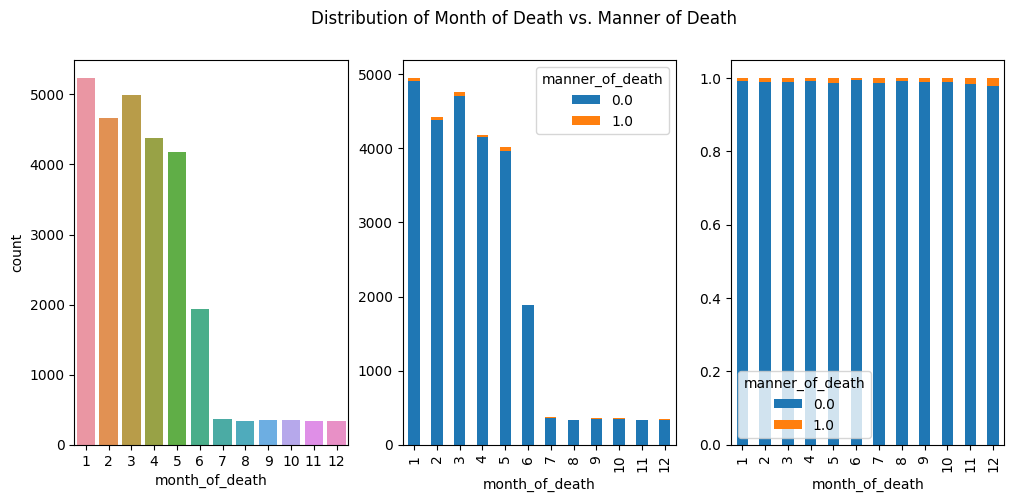

In [16]:
# Value Counts
month_of_death_counts = new_death['month_of_death'].value_counts()
print("month_of_death Frequency:")
print(month_of_death_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Month of Death vs. Manner of Death")

# Plot Counts
sns.countplot(x="month_of_death", data=new_death, ax=axs[0])

# Plot Counts with Overlay
crosstab_month = pd.crosstab(new_death['month_of_death'], new_death['manner_of_death'])
crosstab_month.plot(kind='bar', ax=axs[1], stacked = True)

# Plot Counts with Overlay and Normalization
crosstab_month_norm = crosstab_month.div(crosstab_month.sum(axis=1), axis = 0)
crosstab_month_norm.plot(kind='bar', ax=axs[2], stacked = True)

##### 2.1.3 sex

sex Frequency:
M    14216
F    13261
Name: sex, dtype: int64


<Axes: xlabel='sex'>

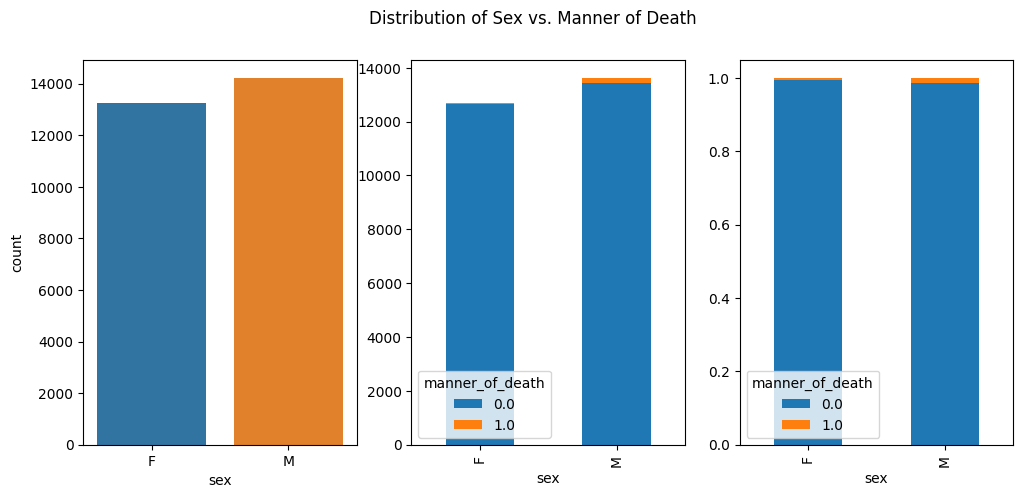

In [17]:
# Value Counts
sex_counts = new_death['sex'].value_counts()
print("sex Frequency:")
print(sex_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Sex vs. Manner of Death")

# Plot Counts
sns.countplot(x="sex", data=new_death, ax=axs[0])

# Plot Counts with Overlay
crosstab_sex = pd.crosstab(new_death['sex'], new_death['manner_of_death'])
crosstab_sex.plot(kind='bar', ax=axs[1], stacked = True)

# Plot Counts with Overlay and Normalization
crosstab_sex_norm = crosstab_sex.div(crosstab_sex.sum(axis=1), axis = 0)
crosstab_sex_norm.plot(kind='bar', ax=axs[2], stacked = True)

##### 2.1.4 place_of_death_and_decedents_status

place_of_death_and_decedents_status Frequency:
4.0    10312
1.0     9081
6.0     3682
7.0     2237
2.0     2084
3.0       49
9.0       31
Name: place_of_death_and_decedents_status, dtype: int64


<Axes: xlabel='place_of_death_and_decedents_status'>

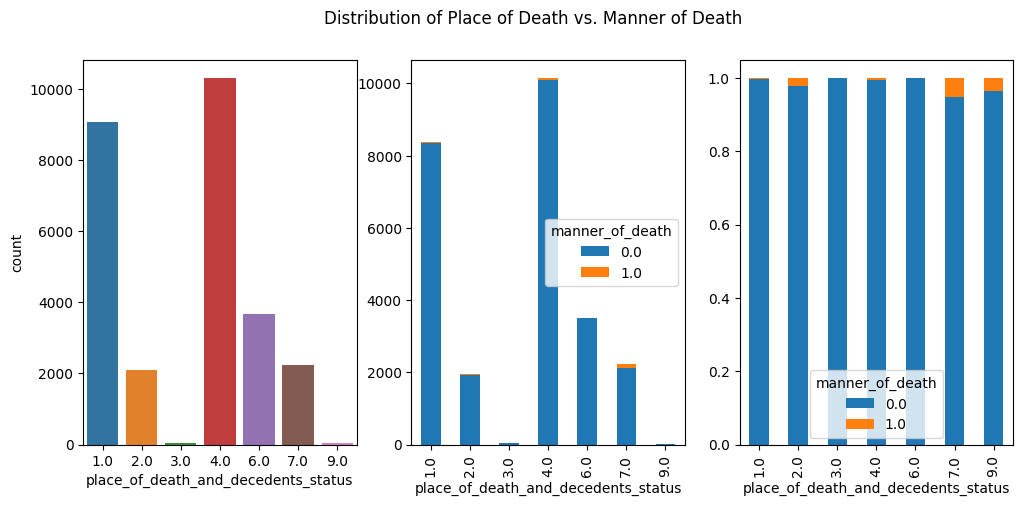

In [18]:
# Value Counts
place_of_death_and_decedents_status_counts = new_death['place_of_death_and_decedents_status'].value_counts()
print("place_of_death_and_decedents_status Frequency:")
print(place_of_death_and_decedents_status_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Place of Death vs. Manner of Death")

# Plot Counts
sns.countplot(x="place_of_death_and_decedents_status", data=new_death, ax=axs[0])

# Plot Counts with Overlay
crosstab_place_of_death_and_decedents_status = pd.crosstab(new_death['place_of_death_and_decedents_status'], new_death['manner_of_death'])
crosstab_place_of_death_and_decedents_status.plot(kind='bar', ax=axs[1], stacked = True)

# Plot Counts with Overlay and Normalization
crosstab_place_of_death_and_decedents_status_norm = crosstab_place_of_death_and_decedents_status.div(crosstab_place_of_death_and_decedents_status.sum(axis=1), axis = 0)
crosstab_place_of_death_and_decedents_status_norm.plot(kind='bar', ax=axs[2], stacked = True)

##### 2.1.5 marital_status

marital_status Frequency:
M    10338
W     9086
D     4573
S     3359
U      120
Name: marital_status, dtype: int64


<Axes: xlabel='marital_status'>

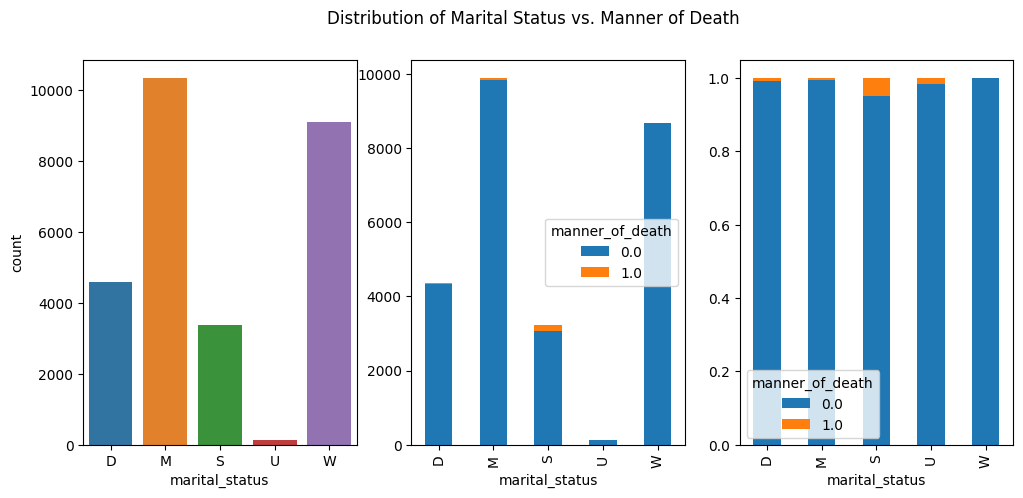

In [19]:
# Value Counts
marital_status_counts = new_death['marital_status'].value_counts()
print("marital_status Frequency:")
print(marital_status_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Marital Status vs. Manner of Death")

# Plot Counts
sns.countplot(x="marital_status", data=new_death, ax=axs[0])

# Plot Counts with Overlay
crosstab_marital_status = pd.crosstab(new_death['marital_status'], new_death['manner_of_death'])
crosstab_marital_status.plot(kind='bar', ax=axs[1], stacked = True)

# Plot Counts with Overlay and Normalization
crosstab_marital_status_norm = crosstab_marital_status.div(crosstab_marital_status.sum(axis=1), axis = 0)
crosstab_marital_status_norm.plot(kind='bar', ax=axs[2], stacked = True)

##### 2.1.6 day_of_week_of_death

day_of_week_of_death Frequency:
7.0    4045
5.0    3992
6.0    3955
1.0    3947
2.0    3933
4.0    3820
3.0    3784
Name: day_of_week_of_death, dtype: int64


<Axes: xlabel='day_of_week_of_death'>

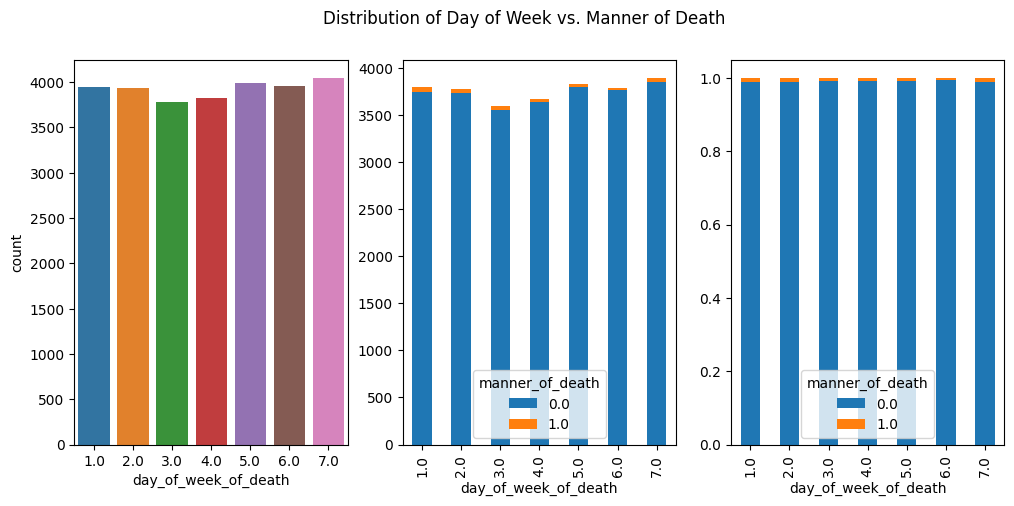

In [20]:
# Value Counts
day_of_week_of_death_counts = new_death['day_of_week_of_death'].value_counts()
print("day_of_week_of_death Frequency:")
print(day_of_week_of_death_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Day of Week vs. Manner of Death")

# Plot Counts
sns.countplot(x="day_of_week_of_death", data=new_death, ax=axs[0])

# Plot Counts with Overlay
crosstab_day_of_week_of_death = pd.crosstab(new_death['day_of_week_of_death'], new_death['manner_of_death'])
crosstab_day_of_week_of_death.plot(kind='bar', ax=axs[1], stacked = True)

# Plot Counts with Overlay and Normalization
crosstab_day_of_week_of_death_norm = crosstab_day_of_week_of_death.div(crosstab_day_of_week_of_death.sum(axis=1), axis = 0)
crosstab_day_of_week_of_death_norm.plot(kind='bar', ax=axs[2], stacked = True)

##### 2.1.7 injury_at_work

injury_at_work Frequency:
U    25448
N     1986
Y       42
Name: injury_at_work, dtype: int64


<Axes: xlabel='injury_at_work'>

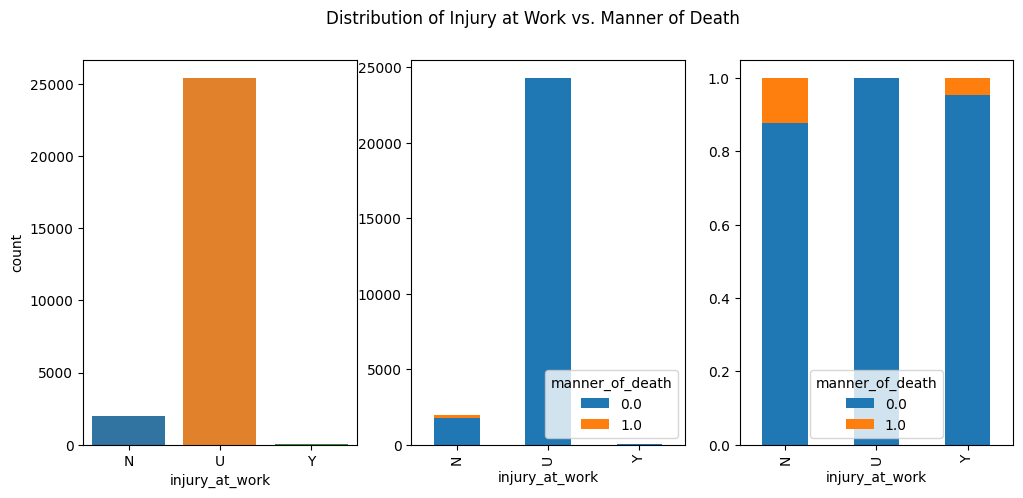

In [21]:
# Value Counts
injury_at_work_counts = new_death['injury_at_work'].value_counts()
print("injury_at_work Frequency:")
print(injury_at_work_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Injury at Work vs. Manner of Death")

# Plot Counts
sns.countplot(x="injury_at_work", data=new_death, ax=axs[0])

# Plot Counts with Overlay
crosstab_injury_at_work = pd.crosstab(new_death['injury_at_work'], new_death['manner_of_death'])
crosstab_injury_at_work.plot(kind='bar', ax=axs[1], stacked = True)

# Plot Counts with Overlay and Normalization
crosstab_injury_at_work_norm = crosstab_injury_at_work.div(crosstab_injury_at_work.sum(axis=1), axis = 0)
crosstab_injury_at_work_norm.plot(kind='bar', ax=axs[2], stacked = True)

##### 2.1.8 method_of_disposition

method_of_disposition Frequency:
U    23288
C     2740
B     1251
R      191
O        5
D        1
Name: method_of_disposition, dtype: int64


<Axes: xlabel='method_of_disposition'>

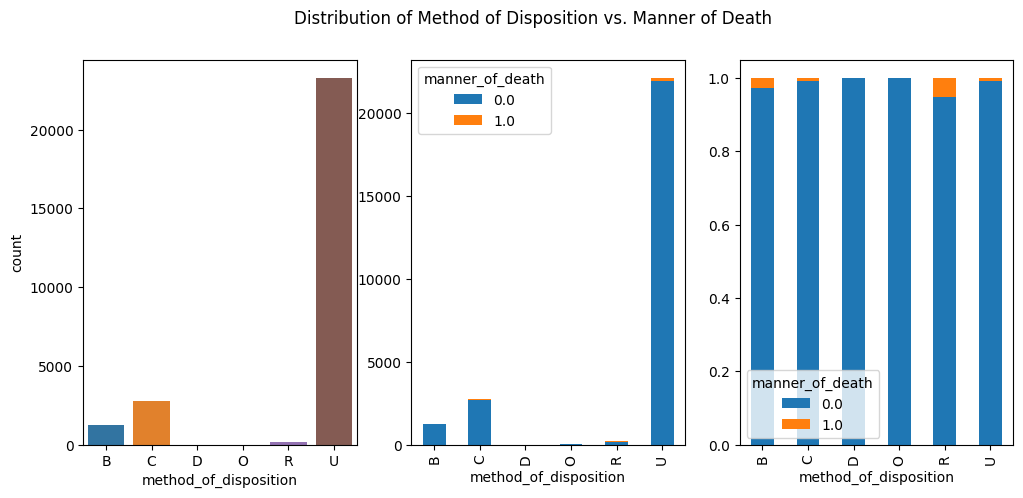

In [22]:
# Value Counts
method_of_disposition_counts = new_death['method_of_disposition'].value_counts()
print("method_of_disposition Frequency:")
print(method_of_disposition_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Method of Disposition vs. Manner of Death")

# Plot Counts
sns.countplot(x="method_of_disposition", data=new_death, ax=axs[0])

# Plot Counts with Overlay
crosstab_method_of_disposition = pd.crosstab(new_death['method_of_disposition'], new_death['manner_of_death'])
crosstab_method_of_disposition.plot(kind='bar', ax=axs[1], stacked = True)

# Plot Counts with Overlay and Normalization
crosstab_method_of_disposition_norm = crosstab_method_of_disposition.div(crosstab_method_of_disposition.sum(axis=1), axis = 0)
crosstab_method_of_disposition_norm.plot(kind='bar', ax=axs[2], stacked = True)

##### 2.1.9 autopsy

autopsy Frequency:
N    21188
U     4529
Y     1759
Name: autopsy, dtype: int64


<Axes: xlabel='autopsy'>

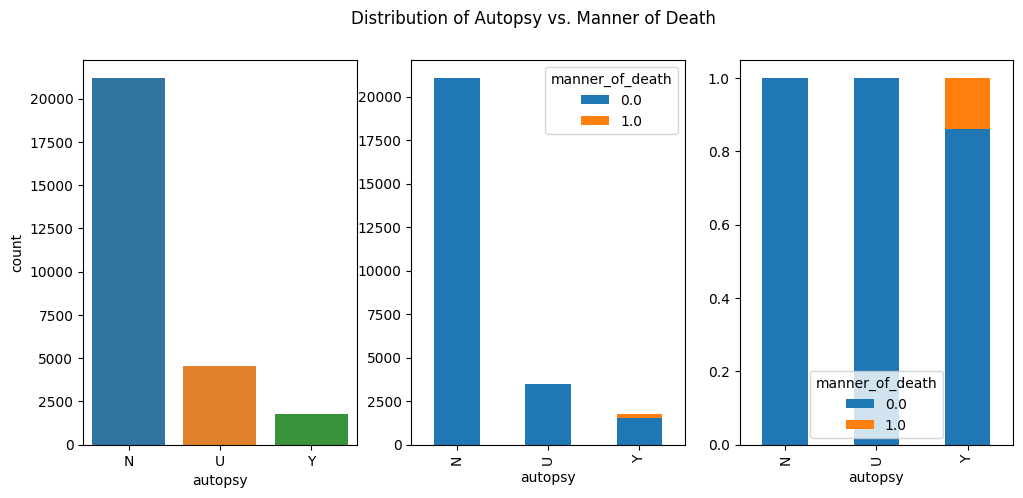

In [23]:
# Value Counts
autopsy_counts = new_death['autopsy'].value_counts()
print("autopsy Frequency:")
print(autopsy_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Autopsy vs. Manner of Death")

# Plot Counts
sns.countplot(x="autopsy", data=new_death, ax=axs[0])

# Plot Counts with Overlay
crosstab_autopsy = pd.crosstab(new_death['autopsy'], new_death['manner_of_death'])
crosstab_autopsy.plot(kind='bar', ax=axs[1], stacked = True)

# Plot Counts with Overlay and Normalization
crosstab_autopsy_norm = crosstab_autopsy.div(crosstab_autopsy.sum(axis=1), axis = 0)
crosstab_autopsy_norm.plot(kind='bar', ax=axs[2], stacked = True)

##### 2.1.10 race

race Frequency:
1.0     21070
2.0      5144
3.0      1048
7.0        72
68.0       36
28.0       30
38.0       29
5.0        22
4.0        14
78.0        7
6.0         2
18.0        1
48.0        1
Name: race, dtype: int64


<Axes: xlabel='race'>

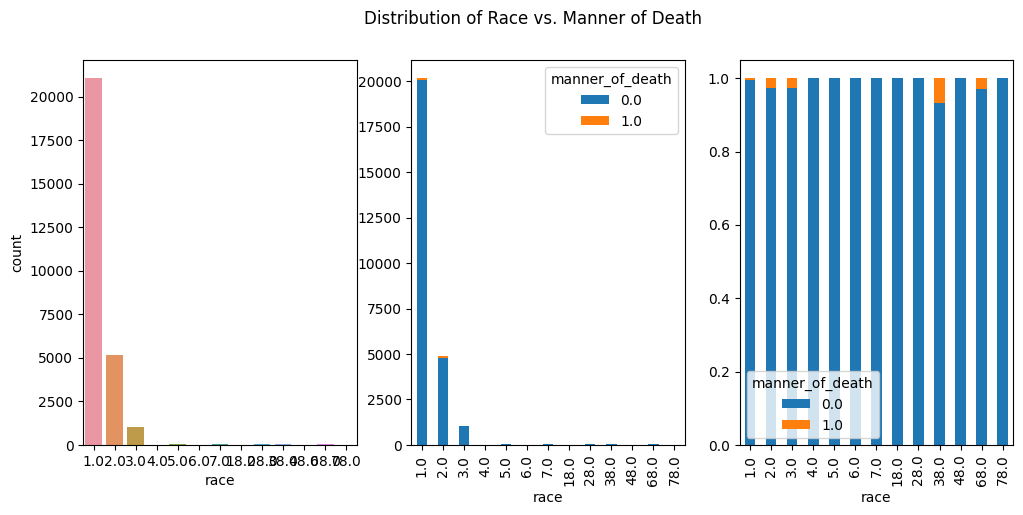

In [24]:
# Value Counts
race_counts = new_death['race'].value_counts()
print("race Frequency:")
print(race_counts)

# Set Up Plot Configuration
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of Race vs. Manner of Death")

# Plot Counts
sns.countplot(x="race", data=new_death, ax=axs[0])

# Plot Counts with Overlay
crosstab_race = pd.crosstab(new_death['race'], new_death['manner_of_death'])
crosstab_race.plot(kind='bar', ax=axs[1], stacked = True)

crosstab_race_norm = crosstab_race.div(crosstab_race.sum(axis=1), axis = 0)
crosstab_race_norm.plot(kind='bar', ax=axs[2], stacked = True)

##### 2.1.11 manner_of_death

manner_of_death Frequency:
0.0    26070
1.0      251
Name: manner_of_death, dtype: int64


<Axes: xlabel='manner_of_death', ylabel='count'>

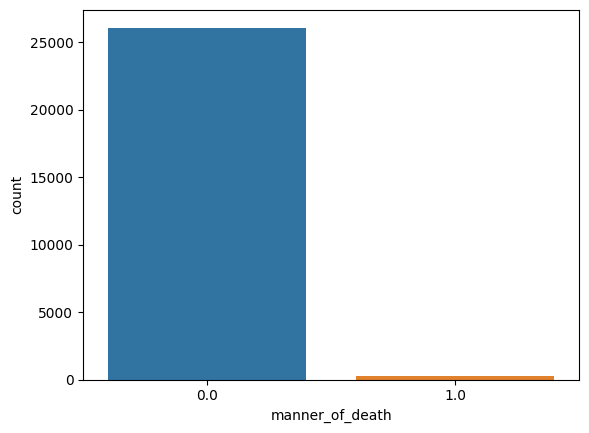

In [25]:
# Value Counts
manner_of_death_counts = new_death['manner_of_death'].value_counts()
print("manner_of_death Frequency:")
print(manner_of_death_counts)

# Plot Counts
sns.countplot(x="manner_of_death", data=new_death)

#### 2.2 Numerical Data Analysis

2.2.1 detail_age

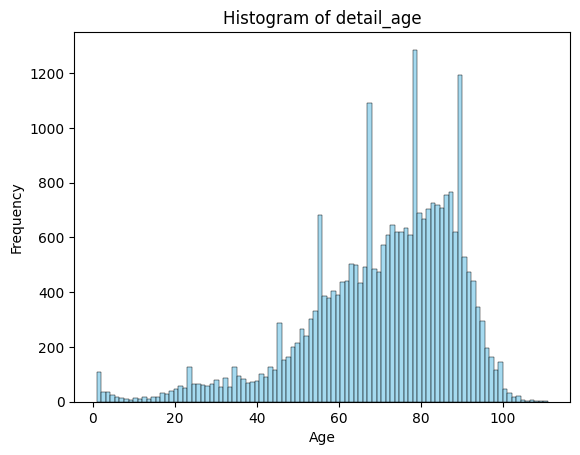

In [26]:
detail_age = new_death['detail_age']
sns.histplot(detail_age, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of detail_age')
plt.show()

There are outliers that are causing a non-representative view of the age distribution. We will remove the outliers.

In [27]:
# Compute z-score for every data point in detail_age
new_death['z_detail_age'] = (new_death['detail_age']-new_death['detail_age'].mean())/new_death['detail_age'].std()
print('Number of rows before discarding outliers = %d' % (new_death.shape[0]))

# Removes rows with a zscore beyond 3 or -3
new_death = new_death[(new_death['z_detail_age'] <= 3) & (new_death['z_detail_age'] >= -3)]
print('Number of rows after discarding missing values = %d' % (new_death.shape[0]))

# Drop the 'C' column
column_name = 'z_detail_age'
new_death.drop(column_name, axis=1, inplace=True)

Number of rows before discarding outliers = 27477
Number of rows after discarding missing values = 27140


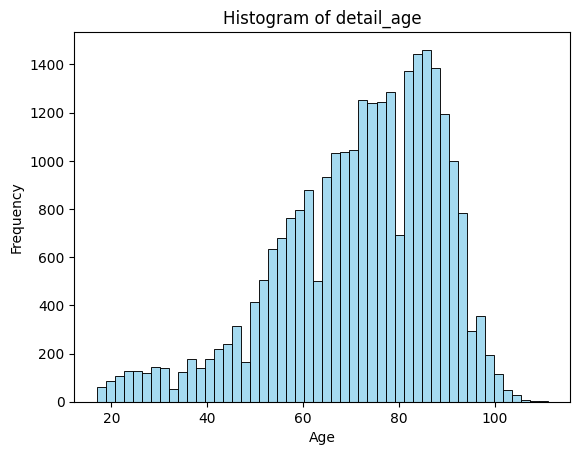

In [28]:
# Plot a Histogram for detail_age
detail_age = new_death['detail_age']
sns.histplot(detail_age, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of detail_age')
plt.show()

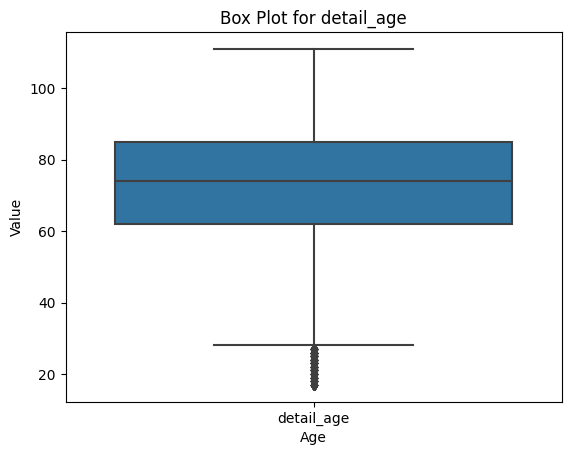

In [29]:
# Plot a Box Plot for detail_age
sns.boxplot(data=new_death[['detail_age']])
plt.xlabel('Age')
plt.ylabel('Value')
plt.title("Box Plot for detail_age")
plt.show()

<Axes: xlabel='detail_age', ylabel='manner_of_death'>

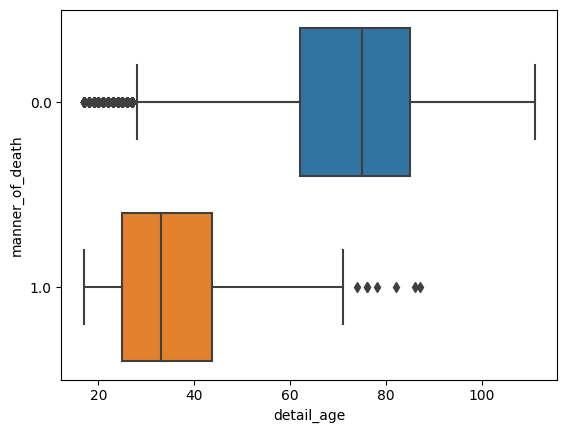

In [30]:
# Plot a Box Plot for detail_age grouped by manner_of_death
sns.boxplot(x="detail_age", y="manner_of_death", data=new_death)

## 3. Data Preprocessing

#### 3.1 Missing Data

In [31]:
# Print Missing Values per Column
missing_values_count = new_death.isnull().sum()
print(missing_values_count)

education_2003_revision                23053
month_of_death                             0
sex                                        0
place_of_death_and_decedents_status        1
marital_status                             1
day_of_week_of_death                       1
injury_at_work                             1
manner_of_death                         1149
method_of_disposition                      1
autopsy                                    1
race                                       1
detail_age                                 0
dtype: int64


In [32]:
# Print Missing Data as percentage (per column)
total_rows = new_death.shape[0]
percent_missing = (missing_values_count / total_rows) * 100
print(percent_missing)

education_2003_revision                84.941046
month_of_death                          0.000000
sex                                     0.000000
place_of_death_and_decedents_status     0.003685
marital_status                          0.003685
day_of_week_of_death                    0.003685
injury_at_work                          0.003685
manner_of_death                         4.233604
method_of_disposition                   0.003685
autopsy                                 0.003685
race                                    0.003685
detail_age                              0.000000
dtype: float64


In [33]:
# Print Total Percent of Missing Data
total_missing_values = new_death.isnull().sum().sum()
total_elements = new_death.size
total_percent_missing = (total_missing_values / total_elements) * 100
print("Total percentage of missing data in the dataset: {:.2f}%".format(total_percent_missing))

Total percentage of missing data in the dataset: 7.43%


In [34]:
# Drop rows with missing values
death_dropped = new_death.dropna()

In [35]:
# Check Missing Values were Dropped
total_missing_values3 = death_dropped.isnull().sum().sum()
total_elements3 = death_dropped.size
total_percent_missing3 = (total_missing_values3 / total_elements3) * 100
print("Total percentage of missing data in the sample dataset: {:.2f}%".format(total_percent_missing3))

Total percentage of missing data in the sample dataset: 0.00%


#### 3.2 Random Sample

In [36]:
# Perform random sampling
sampled_df = death_dropped.sample(frac=0.3, random_state=1)
print('Number of rows after random sampling = %d' % (sampled_df.shape[0]))

Number of rows after random sampling = 1226


#### 2.3 Categorical Correlation Analysis

In [37]:
sampled_df = sampled_df.dropna()
# print(sampled_df)

education_2003_revision and manner_of_death

In [48]:
# Create a cross-tabulation (crosstab) between education_2003_revision and manner_of_death - original data
education_2003_revision_manner_of_death_crosstab = pd.crosstab(new_death['education_2003_revision'], new_death['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between education_2003_revision and manner_of_death: Original")
print(education_2003_revision_manner_of_death_crosstab)

Cross-Tabulation between education_2003_revision and manner_of_death: Original
manner_of_death           0.0  1.0
education_2003_revision           
1.0                       353    0
2.0                       386   15
3.0                      1651   32
4.0                       663    6
5.0                       266    4
6.0                       388    1
7.0                       149    0
8.0                        54    0
9.0                       118    1


In [49]:
# Create a cross-tabulation (crosstab) between education_2003_revision and manner_of_death - sampled data
education_2003_revision_manner_of_death_crosstab2 = pd.crosstab(sampled_df['education_2003_revision'], sampled_df['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between education_2003_revision and manner_of_death: Sampled")
print(education_2003_revision_manner_of_death_crosstab2)

Cross-Tabulation between education_2003_revision and manner_of_death: Sampled
manner_of_death          0.0  1.0
education_2003_revision          
1.0                      111    0
2.0                      130    5
3.0                      468   14
4.0                      187    2
5.0                       89    0
6.0                      124    0
7.0                       41    0
8.0                       17    0
9.0                       38    0


In [50]:
# Perform the chi-square test - education_2003_revision and manner_of_death - original data
chi2, p, dof, expected_edu = chi2_contingency(education_2003_revision_manner_of_death_crosstab)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_edu)

Chi-Square Value: 31.056116455675454
P-value: 0.00013730864273814864
Degrees of Freedom: 8
Expected Frequencies:
[[3.47904086e+02 5.09591387e+00]
 [3.95211157e+02 5.78884267e+00]
 [1.65870418e+03 2.42958160e+01]
 [6.59342305e+02 9.65769513e+00]
 [2.66102276e+02 3.89772449e+00]
 [3.83384390e+02 5.61561047e+00]
 [1.46849034e+02 2.15096648e+00]
 [5.32204551e+01 7.79544898e-01]
 [1.17282114e+02 1.71788598e+00]]


In [51]:
# Perform the chi-square test - education_2003_revision and manner_of_death - sampled data
chi2, p, dof, expected_edu2 = chi2_contingency(education_2003_revision_manner_of_death_crosstab2)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_edu2)

Chi-Square Value: 15.044531416058865
P-value: 0.05828533636310863
Degrees of Freedom: 8
Expected Frequencies:
[[1.09098695e+02 1.90130506e+00]
 [1.32687602e+02 2.31239804e+00]
 [4.73743883e+02 8.25611746e+00]
 [1.85762643e+02 3.23735726e+00]
 [8.74755302e+01 1.52446982e+00]
 [1.21876020e+02 2.12398042e+00]
 [4.02977162e+01 7.02283850e-01]
 [1.67088091e+01 2.91190865e-01]
 [3.73491028e+01 6.50897227e-01]]


month_of_death and manner_of_death

In [ ]:
# Create a cross-tabulation (crosstab) between month_of_death and manner_of_death - original data
month_of_death_manner_of_death_crosstab = pd.crosstab(new_death['month_of_death'], new_death['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between month_of_death and manner_of_death: Original")
print(month_of_death_manner_of_death_crosstab)

In [ ]:
# Create a cross-tabulation (crosstab) between month_of_death and manner_of_death - sampled data
month_of_death_manner_of_death_crosstab2 = pd.crosstab(sampled_df['month_of_death'], sampled_df['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between month_of_death and manner_of_death: Sampled")
print(month_of_death_manner_of_death_crosstab2)

In [ ]:
# Perform the chi-square test - month_of_death and manner_of_death - original data
chi2, p, dof, expected_month = chi2_contingency(month_of_death_manner_of_death_crosstab)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_month)

In [ ]:
# Perform the chi-square test - month_of_death and manner_of_death - Sampled data
chi2, p, dof, expected_month2 = chi2_contingency(month_of_death_manner_of_death_crosstab2)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_month2)

sex and manner_of_death




In [ ]:
# Create a cross-tabulation (crosstab) between sex and manner_of_death - original data
sex_manner_of_death_crosstab = pd.crosstab(new_death['sex'], new_death['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between sex and manner_of_death:")
print(sex_manner_of_death_crosstab)

In [ ]:
# Create a cross-tabulation (crosstab) between sex and manner_of_death - sampled data
sex_manner_of_death_crosstab2 = pd.crosstab(sampled_df['sex'], sampled_df['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between sex and manner_of_death:")
print(sex_manner_of_death_crosstab2)

In [ ]:
# Perform the chi-square test - Original Data sex and manner_of_death
chi2, p, dof, expected_sex = chi2_contingency(sex_manner_of_death_crosstab)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_sex)

In [ ]:
# Perform the chi-square test - Sampled Data sex and manner_of_death
chi2, p, dof, expected2 = chi2_contingency(sex_manner_of_death_crosstab2)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected2)

place_of_death_and_decedents_status and manner_of_death

In [ ]:
# Create a cross-tabulation (crosstab) between place_of_death_and_decedents_status and manner_of_death - original data
place_of_death_and_decedents_status_manner_of_death_crosstab = pd.crosstab(new_death['place_of_death_and_decedents_status'], new_death['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between place_of_death_and_decedents_status and manner_of_death: Original")
print(place_of_death_and_decedents_status_manner_of_death_crosstab)

In [ ]:
# Create a cross-tabulation (crosstab) between sex and manner_of_death - sampled data
place_of_death_and_decedents_status_manner_of_death_crosstab2 = pd.crosstab(sampled_df['place_of_death_and_decedents_status'], sampled_df['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between place_of_death_and_decedents_status and manner_of_death: Sampled")
print(place_of_death_and_decedents_status_manner_of_death_crosstab2)

In [ ]:
# Perform the chi-square test - Original Data place_of_death_and_decedents_status and manner_of_death
chi2, p, dof, expected_place = chi2_contingency(place_of_death_and_decedents_status_manner_of_death_crosstab)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_place)

In [ ]:
# Perform the chi-square test - Original Data place_of_death_and_decedents_status and manner_of_death
chi2, p, dof, expected_place2 = chi2_contingency(place_of_death_and_decedents_status_manner_of_death_crosstab2)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_place2)

marital_status and manner_of_death

In [ ]:
# Create a cross-tabulation (crosstab) between marital_status and manner_of_death - original data
marital_status_manner_of_death_crosstab = pd.crosstab(new_death['marital_status'], new_death['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between marital_status and manner_of_death: Original")
print(marital_status_manner_of_death_crosstab)

In [ ]:
# Create a cross-tabulation (crosstab) between marital_status and manner_of_death - sampled data
marital_status_manner_of_death_crosstab2 = pd.crosstab(sampled_df['marital_status'], sampled_df['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between marital_status and manner_of_death: Sampled")
print(marital_status_manner_of_death_crosstab2)

In [ ]:
# Perform the chi-square test - marital_status and manner_of_death - original data
chi2, p, dof, expected_marital = chi2_contingency(marital_status_manner_of_death_crosstab)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_marital)

In [ ]:
# Perform the chi-square test - marital_status and manner_of_death - original data
chi2, p, dof, expected_marital2 = chi2_contingency(marital_status_manner_of_death_crosstab2)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_marital2)

day_of_week_of_death and manner_of_death

In [54]:
# Create a cross-tabulation (crosstab) between day_of_week_of_death and manner_of_death - original data
day_of_week_of_death_manner_of_death_crosstab = pd.crosstab(new_death['day_of_week_of_death'], new_death['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between day_of_week_of_death and manner_of_death: Original")
print(day_of_week_of_death_manner_of_death_crosstab)

Cross-Tabulation between day_of_week_of_death and manner_of_death: Original
manner_of_death        0.0  1.0
day_of_week_of_death           
1.0                   3692   44
2.0                   3683   39
3.0                   3514   30
4.0                   3594   27
5.0                   3754   30
6.0                   3717   23
7.0                   3803   41


In [55]:
# Create a cross-tabulation (crosstab) between day_of_week_of_death and manner_of_death - sampled data
day_of_week_of_death_manner_of_death_crosstab2 = pd.crosstab(sampled_df['day_of_week_of_death'], sampled_df['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between day_of_week_of_death and manner_of_death: Sampled")
print(day_of_week_of_death_manner_of_death_crosstab2)

Cross-Tabulation between day_of_week_of_death and manner_of_death: Sampled
manner_of_death       0.0  1.0
day_of_week_of_death          
1.0                   168    8
2.0                   160    3
3.0                   182    1
4.0                   186    1
5.0                   177    4
6.0                   163    1
7.0                   169    3


In [56]:
# Perform the chi-square test - day_of_week_of_death and manner_of_death - original data
chi2, p, dof, expected_day = chi2_contingency(day_of_week_of_death_manner_of_death_crosstab)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_day)

Chi-Square Value: 10.310569925232986
P-value: 0.11216789887684568
Degrees of Freedom: 6
Expected Frequencies:
[[3702.36435689   33.63564311]
 [3688.49040052   33.50959948]
 [3512.09295525   31.90704475]
 [3588.39971529   32.60028471]
 [3749.9322073    34.0677927 ]
 [3706.32834443   33.67165557]
 [3809.39202031   34.60797969]]


In [57]:
# Perform the chi-square test - day_of_week_of_death and manner_of_death - sampled data
chi2, p, dof, expected_day2 = chi2_contingency(day_of_week_of_death_manner_of_death_crosstab2)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_day2)

Chi-Square Value: 12.876246067723777
P-value: 0.045043807751598504
Degrees of Freedom: 6
Expected Frequencies:
[[172.98531811   3.01468189]
 [160.20799347   2.79200653]
 [179.86541599   3.13458401]
 [183.79690049   3.20309951]
 [177.89967374   3.10032626]
 [161.1908646    2.8091354 ]
 [169.05383361   2.94616639]]


 injury_at_work and manner_of_death

In [58]:
# Create a cross-tabulation (crosstab) between  injury_at_work and manner_of_death - original data
injury_at_work_manner_of_death_crosstab = pd.crosstab(new_death['injury_at_work'], new_death['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between injury_at_work and manner_of_death: Original")
print(injury_at_work_manner_of_death_crosstab)

Cross-Tabulation between day_of_week_of_death and manner_of_death: Original
manner_of_death    0.0  1.0
injury_at_work             
N                 1638  226
U                24080    6
Y                   39    2


In [59]:
# Create a cross-tabulation (crosstab) between injury_at_work and manner_of_death - sampled data
injury_at_work_manner_of_death_crosstab2 = pd.crosstab(sampled_df['injury_at_work'], sampled_df['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between injury_at_work and manner_of_death: Sampled")
print(injury_at_work_manner_of_death_crosstab2)

Cross-Tabulation between day_of_week_of_death and manner_of_death: Sampled
manner_of_death   0.0  1.0
injury_at_work            
N                 193   21
U                1008    0
Y                   4    0


In [60]:
# Perform the chi-square test - injury_at_work and manner_of_death - Original data
chi2, p, dof, expected_injury = chi2_contingency(injury_at_work_manner_of_death_crosstab)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_injury)

Chi-Square Value: 2846.1602930237323
P-value: 0.0
Degrees of Freedom: 2
Expected Frequencies:
[[1.84721819e+03 1.67818091e+01]
 [2.38691509e+04 2.16849063e+02]
 [4.06308722e+01 3.69127775e-01]]


In [61]:
# Perform the chi-square test - injury_at_work and manner_of_death - Original data
chi2, p, dof, expected_injury2 = chi2_contingency(injury_at_work_manner_of_death_crosstab2)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_injury2)

Chi-Square Value: 101.03909721952924
P-value: 1.1471991341409945e-22
Degrees of Freedom: 2
Expected Frequencies:
[[2.10334421e+02 3.66557912e+00]
 [9.90734095e+02 1.72659054e+01]
 [3.93148450e+00 6.85154976e-02]]


method_of_disposition and manner_of_death

In [62]:
# Create a cross-tabulation (crosstab) between method_of_disposition and manner_of_death - original data
method_of_disposition_manner_of_death_crosstab = pd.crosstab(new_death['method_of_disposition'], new_death['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between method_of_disposition and manner_of_death: Original")
print(method_of_disposition_manner_of_death_crosstab)

Cross-Tabulation between method_of_disposition and manner_of_death: Original
manner_of_death          0.0  1.0
method_of_disposition            
B                       1166   31
C                       2672   19
D                          1    0
O                          5    0
R                        179    9
U                      21734  175


In [63]:
# Create a cross-tabulation (crosstab) between method_of_disposition and manner_of_death - Sampled data
method_of_disposition_manner_of_death_crosstab2 = pd.crosstab(sampled_df['method_of_disposition'], sampled_df['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between method_of_disposition and manner_of_death: Sampled")
print(method_of_disposition_manner_of_death_crosstab2)

Cross-Tabulation between method_of_disposition and manner_of_death: Sampled
manner_of_death        0.0  1.0
method_of_disposition          
B                      360   11
C                      797    8
O                        1    0
R                       46    2
U                        1    0


In [64]:
# Perform the chi-square test - method_of_disposition and manner_of_death - Original data
chi2, p, dof, expected_method = chi2_contingency(method_of_disposition_manner_of_death_crosstab)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_method)

Chi-Square Value: 73.85519370893867
P-value: 1.6123432095860783e-14
Degrees of Freedom: 5
Expected Frequencies:
[[1.18622327e+03 1.07767304e+01]
 [2.66677261e+03 2.42273864e+01]
 [9.90996884e-01 9.00311646e-03]
 [4.95498442e+00 4.50155823e-02]
 [1.86307414e+02 1.69258590e+00]
 [2.17117507e+04 1.97249279e+02]]


In [65]:
# Perform the chi-square test - method_of_disposition and manner_of_death - Sampled data
chi2, p, dof, expected_method2 = chi2_contingency(method_of_disposition_manner_of_death_crosstab2)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_method2)

Chi-Square Value: 7.678762925582628
P-value: 0.10408009342271254
Degrees of Freedom: 4
Expected Frequencies:
[[3.64645188e+02 6.35481240e+00]
 [7.91211256e+02 1.37887439e+01]
 [9.82871126e-01 1.71288744e-02]
 [4.71778140e+01 8.22185971e-01]
 [9.82871126e-01 1.71288744e-02]]


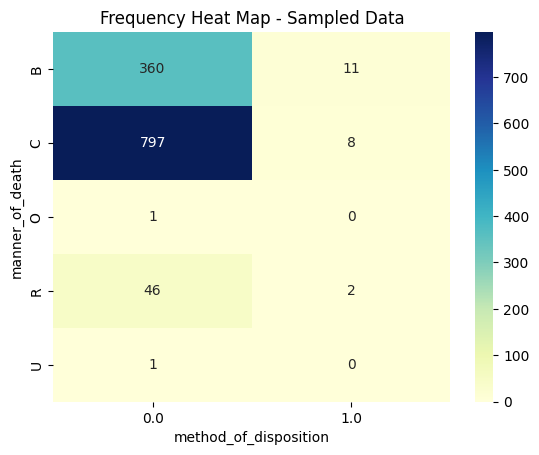

In [80]:
# Create a heat map
sns.heatmap(method_of_disposition_manner_of_death_crosstab2, annot=True, cmap='YlGnBu', fmt='d')

plt.title("Frequency Heat Map - Sampled Data")
plt.xlabel("method_of_disposition")
plt.ylabel("manner_of_death")

plt.show()

autopsy and manner_of_death

In [66]:
# Create a cross-tabulation (crosstab) between autopsy and manner_of_death - original data
autopsy_manner_of_death_crosstab = pd.crosstab(new_death['autopsy'], new_death['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between autopsy and manner_of_death: Original")
print(autopsy_manner_of_death_crosstab)

Cross-Tabulation between autopsy and manner_of_death: Original
manner_of_death    0.0  1.0
autopsy                    
N                20901    5
U                 3468    0
Y                 1388  229


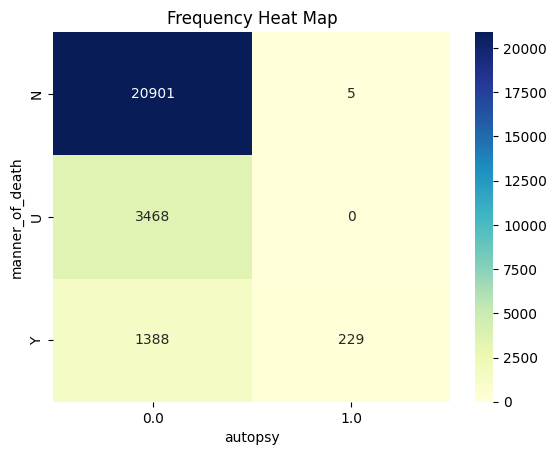

In [79]:
# Create a heat map
sns.heatmap(autopsy_manner_of_death_crosstab, annot=True, cmap='YlGnBu', fmt='d')

plt.title("Frequency Heat Map")
plt.xlabel("autopsy")
plt.ylabel("manner_of_death")

plt.show()


In [67]:
# Create a cross-tabulation (crosstab) between autopsy and manner_of_death - Sampled data
autopsy_manner_of_death_crosstab2 = pd.crosstab(sampled_df['autopsy'], sampled_df['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between autopsy and manner_of_death: Sampled")
print(autopsy_manner_of_death_crosstab2)

Cross-Tabulation between autopsy and manner_of_death: Sampled
manner_of_death   0.0  1.0
autopsy                   
N                1065    0
U                   2    0
Y                 138   21


In [68]:
# Perform the chi-square test - autopsy and manner_of_death - Original data
chi2, p, dof, expected_autopsy = chi2_contingency(autopsy_manner_of_death_crosstab)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_autopsy)

Chi-Square Value: 3398.935952826779
P-value: 0.0
Degrees of Freedom: 2
Expected Frequencies:
[[2.07177808e+04 1.88219153e+02]
 [3.43677719e+03 3.12228079e+01]
 [1.60244196e+03 1.45580393e+01]]


In [70]:
# Perform the chi-square test - autopsy and manner_of_death - Sampled data
chi2, p, dof, expected_autopsy2 = chi2_contingency(autopsy_manner_of_death_crosstab2)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_autopsy2)

Chi-Square Value: 143.38047443826824
P-value: 7.333741019222907e-32
Degrees of Freedom: 2
Expected Frequencies:
[[1.04675775e+03 1.82422512e+01]
 [1.96574225e+00 3.42577488e-02]
 [1.56276509e+02 2.72349103e+00]]


race and manner_of_death

In [71]:
# Create a cross-tabulation (crosstab) between race and manner_of_death - original data
race_manner_of_death_crosstab = pd.crosstab(new_death['race'], new_death['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between race and manner_of_death: Original")
print(race_manner_of_death_crosstab)

Cross-Tabulation between race and manner_of_death: Original
manner_of_death    0.0  1.0
race                       
1.0              19923   85
2.0               4662  119
3.0                968   28
4.0                 14    0
5.0                 21    0
6.0                  2    0
7.0                 72    0
18.0                 1    0
28.0                30    0
38.0                25    1
48.0                 1    0
68.0                31    1
78.0                 7    0


In [76]:
# Create a cross-tabulation (crosstab) between race and manner_of_death - sampled data
race_manner_of_death_crosstab2 = pd.crosstab(sampled_df['race'], sampled_df['manner_of_death'])

# Print the cross-tabulation
print("Cross-Tabulation between race and manner_of_death: Sampled")
print(race_manner_of_death_crosstab2)

Cross-Tabulation between race and manner_of_death: Sampled
manner_of_death  0.0  1.0
race                     
1.0              849    7
2.0               44    2
3.0              259   12
4.0                5    0
5.0                2    0
6.0                1    0
7.0               18    0
28.0              10    0
38.0               5    0
68.0               9    0
78.0               3    0


In [77]:
# Perform the chi-square test - race and manner_of_death - Original data
chi2, p, dof, expected_race = chi2_contingency(race_manner_of_death_crosstab)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_race)

Chi-Square Value: 232.3643872853391
P-value: 6.429288787760035e-43
Degrees of Freedom: 12
Expected Frequencies:
[[1.98278656e+04 1.80134354e+02]
 [4.73795610e+03 4.30438998e+01]
 [9.87032896e+02 8.96710400e+00]
 [1.38739564e+01 1.26043630e-01]
 [2.08109346e+01 1.89065446e-01]
 [1.98199377e+00 1.80062329e-02]
 [7.13517756e+01 6.48224385e-01]
 [9.90996884e-01 9.00311646e-03]
 [2.97299065e+01 2.70093494e-01]
 [2.57659190e+01 2.34081028e-01]
 [9.90996884e-01 9.00311646e-03]
 [3.17119003e+01 2.88099727e-01]
 [6.93697818e+00 6.30218152e-02]]


In [78]:
# Perform the chi-square test - race and manner_of_death - Sampled data
chi2, p, dof, expected_race2 = chi2_contingency(race_manner_of_death_crosstab2)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_race2)

Chi-Square Value: 18.761480990896178
P-value: 0.043398935272755595
Degrees of Freedom: 10
Expected Frequencies:
[[8.41337684e+02 1.46623165e+01]
 [4.52120718e+01 7.87928222e-01]
 [2.66358075e+02 4.64192496e+00]
 [4.91435563e+00 8.56443719e-02]
 [1.96574225e+00 3.42577488e-02]
 [9.82871126e-01 1.71288744e-02]
 [1.76916803e+01 3.08319739e-01]
 [9.82871126e+00 1.71288744e-01]
 [4.91435563e+00 8.56443719e-02]
 [8.84584013e+00 1.54159869e-01]
 [2.94861338e+00 5.13866232e-02]]


In [ ]:
https://colab.research.google.com/drive/1ucg-1x5tjx1u4b1bf2cRe2qIPgyqDbV0#scrollTo=cSSUe7cjLyIp&line=1&uniqifier=1

Multi Index Cross-Tabulation and Chi-Square

In [ ]:
# Create a multivariate cross-tabulation (crosstab) between selected categorical variables
multi_index_crosstab = pd.crosstab(index=[sampled_df['education_2003_revision'], sampled_df['month_of_death'],
                                          sampled_df['sex'], sampled_df['place_of_death_and_decedents_status']],
                                   columns=sampled_df['manner_of_death'])

# Print the multi-index cross-tabulation
print("Multi-Index Cross-Tabulation:")
print(multi_index_crosstab)

Multi-Index Cross-Tabulation:
manner_of_death                                                                 0.0  \
education_2003_revision month_of_death sex place_of_death_and_decedents_status        
1.0                     1              F   1.0                                    3   
                                           2.0                                    1   
                                           4.0                                    2   
                                           6.0                                    2   
                                       M   1.0                                    2   
...                                                                             ...   
9.0                     11             M   2.0                                    1   
                                           4.0                                    1   
                        12             M   2.0                                    1   
             

In [ ]:
# Perform the chi-square test - multi_index_crosstab2 - Sampled Data
chi2, p, dof, expected_EMSP = chi2_contingency(multi_index_crosstab)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_EMSP)

Chi-Square Value: 462.2035787387192
P-value: 0.9672906173606369
Degrees of Freedom: 520
Expected Frequencies:
[[2.94861338 0.05138662]
 [0.98287113 0.01712887]
 [1.96574225 0.03425775]
 ...
 [0.98287113 0.01712887]
 [1.96574225 0.03425775]
 [0.98287113 0.01712887]]


In [ ]:
# Create a multivariate cross-tabulation (crosstab) between selected categorical variables and 'manner_of_death'
multi_index_crosstab2 = pd.crosstab(index=[sampled_df['marital_status'], sampled_df['day_of_week_of_death'],
                                          sampled_df['injury_at_work'], sampled_df['method_of_disposition']],
                                   columns=sampled_df['manner_of_death'])

# Print the multi-index cross-tabulation
print("Multi-Index Cross-Tabulation:")
print(multi_index_crosstab2)

Multi-Index Cross-Tabulation:
manner_of_death                                                           0.0  \
marital_status day_of_week_of_death injury_at_work method_of_disposition        
D              1.0                  N              B                        1   
                                                   C                        6   
                                    U              B                        6   
                                                   C                       19   
                                                   R                        1   
...                                                                       ...   
W              7.0                  N              C                        3   
                                                   R                        1   
                                    U              B                       12   
                                                   C                       31  

In [ ]:
# Perform the chi-square test - multi_index_crosstab2 - Sampled Data
chi2, p, dof, expected_MDIM = chi2_contingency(multi_index_crosstab2)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_MDIM)

Chi-Square Value: 443.2849218580931
P-value: 1.9346616919377536e-28
Degrees of Freedom: 160
Expected Frequencies:
[[9.82871126e-01 1.71288744e-02]
 [6.88009788e+00 1.19902121e-01]
 [5.89722675e+00 1.02773246e-01]
 [1.86745514e+01 3.25448613e-01]
 [9.82871126e-01 1.71288744e-02]
 [9.82871126e-01 1.71288744e-02]
 [4.91435563e+00 8.56443719e-02]
 [4.91435563e+00 8.56443719e-02]
 [2.35889070e+01 4.11092985e-01]
 [9.82871126e-01 1.71288744e-02]
 [9.82871126e-01 1.71288744e-02]
 [8.84584013e+00 1.54159869e-01]
 [1.08115824e+01 1.88417618e-01]
 [2.75203915e+01 4.79608483e-01]
 [1.96574225e+00 3.42577488e-02]
 [9.82871126e-01 1.71288744e-02]
 [1.96574225e+00 3.42577488e-02]
 [9.82871126e-01 1.71288744e-02]
 [6.88009788e+00 1.19902121e-01]
 [3.04690049e+01 5.30995106e-01]
 [9.82871126e-01 1.71288744e-02]
 [9.82871126e-01 1.71288744e-02]
 [9.82871126e-01 1.71288744e-02]
 [5.89722675e+00 1.02773246e-01]
 [8.84584013e+00 1.54159869e-01]
 [2.06402936e+01 3.59706362e-01]
 [1.96574225e+00 3.42577488e

In [ ]:
# Create a multivariate cross-tabulation (crosstab) between selected categorical variables and 'manner_of_death'
multi_index_crosstab3 = pd.crosstab(index=[sampled_df['autopsy'], sampled_df['race']],
                                   columns=sampled_df['manner_of_death'])

# Print the multi-index cross-tabulation
print("Multi-Index Cross-Tabulation:")
print(multi_index_crosstab3)

Multi-Index Cross-Tabulation:
manner_of_death  0.0  1.0
autopsy race             
N       1.0      762    0
        2.0       37    0
        3.0      219    0
        4.0        5    0
        5.0        2    0
        6.0        1    0
        7.0       17    0
        28.0       8    0
        38.0       4    0
        68.0       8    0
        78.0       2    0
U       1.0        1    0
        28.0       1    0
Y       1.0       86    7
        2.0        7    2
        3.0       40   12
        7.0        1    0
        28.0       1    0
        38.0       1    0
        68.0       1    0
        78.0       1    0


In [ ]:
# Perform the chi-square test - multi_index_crosstab3 - Sampled Data
chi2, p, dof, expected_AR = chi2_contingency(multi_index_crosstab3)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected_AR)

Chi-Square Value: 200.817046207757
P-value: 7.755893350473904e-32
Degrees of Freedom: 20
Expected Frequencies:
[[7.48947798e+02 1.30522023e+01]
 [3.63662316e+01 6.33768352e-01]
 [2.15248777e+02 3.75122349e+00]
 [4.91435563e+00 8.56443719e-02]
 [1.96574225e+00 3.42577488e-02]
 [9.82871126e-01 1.71288744e-02]
 [1.67088091e+01 2.91190865e-01]
 [7.86296900e+00 1.37030995e-01]
 [3.93148450e+00 6.85154976e-02]
 [7.86296900e+00 1.37030995e-01]
 [1.96574225e+00 3.42577488e-02]
 [9.82871126e-01 1.71288744e-02]
 [9.82871126e-01 1.71288744e-02]
 [9.14070147e+01 1.59298532e+00]
 [8.84584013e+00 1.54159869e-01]
 [5.11092985e+01 8.90701468e-01]
 [9.82871126e-01 1.71288744e-02]
 [9.82871126e-01 1.71288744e-02]
 [9.82871126e-01 1.71288744e-02]
 [9.82871126e-01 1.71288744e-02]
 [9.82871126e-01 1.71288744e-02]]


##### 2.3.2 Cramer's V

In [ ]:
# Convert the categorical data to numerical labels (optional if already numeric)
for column in sampled_df.columns:
    sampled_df[column] = pd.Categorical(sampled_df[column]).codes

# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['detail_age'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

In [ ]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['race'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

In [ ]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['sex'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

In [ ]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['autopsy'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

In [ ]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['marital_status'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

In [ ]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['month_of_death'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

In [ ]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['education_2003_revision'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

In [ ]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['day_of_week_of_death'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

In [ ]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['injury_at_work'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

In [ ]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['method_of_disposition'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

In [ ]:
# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a contingency table for the two categorical variables
confusion_matrix = pd.crosstab(sampled_df['manner_of_death'], sampled_df['injury_at_work'])

# Calculate Cramér's V
cramers_v_value = cramers_v(confusion_matrix)
print("Cramér's V:", cramers_v_value)

#### 3.3 Normalize Data and Encode Categorical Variables

In [ ]:
# Normalize detail_age using Min-Max scaler
mms = MinMaxScaler()
sampled_df[['detail_age']] = mms.fit_transform(sampled_df[['detail_age']])

In [ ]:
# Perform one-hot encoding on categorical columns
encoded_df = pd.get_dummies(sampled_df, columns=['education_2003_revision', 'month_of_death', 'sex', 'place_of_death_and_decedents_status', 'marital_status', 'day_of_week_of_death', 'injury_at_work','method_of_disposition', 'autopsy', 'race'],
                            prefix=['education_2003_revision', 'month_of_death', 'sex', 'place_of_death_and_decedents_status', 'marital_status', 'day_of_week_of_death', 'injury_at_work','method_of_disposition', 'autopsy', 'race'])

#### 3.4 Class Imbalances

In [ ]:
# Calculate class proportions
class_proportions = encoded_df['manner_of_death'].value_counts(normalize=True)

print(class_proportions)

In [ ]:
# Split data for rebalancing
train, test = train_test_split(encoded_df, test_size=0.3, random_state=42)

In [ ]:
# Identify current proportion of homicide records
total = train.shape[0]
print('\nTotal number of instances in train sample: ', total)

homicide = train['manner_of_death'].value_counts()[1]
print('\nTotal number of homicide instances in train sample: ', homicide)

# Calculate number to resample
x = ((0.2 * total) - homicide) / 0.8
print('\nNumber of homicide records to resample: ', int(x))

# Resample data to increase number of homicide records
to_resample = train.loc[train['manner_of_death'] == 1]
our_resample = to_resample.sample(n = int(x), replace = True)
encoded_df_rebal = pd.concat([train, our_resample])
encoded_df_rebal['manner_of_death'].value_counts()

# Check percentage is met
ratio = encoded_df_rebal['manner_of_death'].value_counts()[1] / encoded_df_rebal.shape[0] * 100
print('\nNew percent of homicide records: ', round(ratio, 0))

## 4. Modeling - Artifical Neural Networks

#### 4.1 ANN Models WITHOUT Data Rebalance

In [ ]:
# select features for model
selected_features = [col for col in encoded_df.columns if col != 'manner_of_death']

target_variable = 'manner_of_death'

In [ ]:
# select X and y variables
X = encoded_df[selected_features]
y = encoded_df[target_variable]

In [ ]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##### 4.1.1 Basic ANN Model withOUT Hidden Layers

In [ ]:
# build the ANN model
model_nolay = keras.Sequential([
    layers.Dense(1, activation='sigmoid', input_shape=(X_train.shape[1],))
])

# compile the model
model_nolay.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# train the model
model_nolay.fit(X_train, y_train, epochs=10, batch_size=32)

In [ ]:
# evaluate the model
loss_nolay, accuracy_nolay = model_nolay.evaluate(X_test, y_test)
print(f"Test accuracy (Model_nolay): {accuracy_nolay}")

##### 4.1.2 Basic ANN Model with Hidden Layers

In [ ]:
# build the ANN model --> 3 hidden layers, 64 neurons on 1st, 32 neurons on 2nd, and 1 output neuron on last
model_lay = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_lay.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# train the ANN model
model_lay.fit(X_train, y_train, epochs=10, batch_size=32)

In [ ]:
# evaluate the model
loss_lay, accuracy_lay = model_lay.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy_lay}")

In [ ]:
# visualize the ANN model
def visualize_model(model_lay):
    G = nx.DiGraph()
    node_labels = {}
    for i, layer in enumerate(model_lay.layers):
        layer_name = f'{layer.name}\n{layer.output_shape}'
        node_labels[i] = layer_name
        G.add_node(layer_name)
        if i > 0:
            G.add_edge(node_labels[i - 1], layer_name)

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold')
    plt.title("Neural Network Model Architecture")
    plt.savefig('model_visualization.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

# Call the function to visualize the model
visualize_model(model_lay)

##### 4.1.3 ANN Model w/ Reduced Complexity (Reduced amount of hidden layers)

In [ ]:
# build model with reduced complexity --> 3 hidden layers, 32 neurons on 1st, 16 neurons on 2nd, and 1 output neuron on last
model_red = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# compile the model
model_red.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# train the model with reduced complexity
model_red.fit(X_train, y_train, epochs=10, batch_size=32)

In [ ]:
# evaluate the model with reduced complexity
loss_red, accuracy_red = model_red.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy_red}")

In [ ]:
# visualize model with reduced complexity
def visualize_model(model_red):
    G = nx.DiGraph()
    node_labels = {}
    for i, layer in enumerate(model_red.layers):
        layer_name = f'{layer.name}\n{layer.output_shape}'
        node_labels[i] = layer_name
        G.add_node(layer_name)
        if i > 0:
            G.add_edge(node_labels[i - 1], layer_name)

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold')
    plt.title("Neural Network Model Architecture (Reduced Complexity)")
    plt.savefig('model_red_visualization.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

# call function to visualize
visualize_model(model_red)

##### 4.1.4 ANN Model with Regularization

In [ ]:
# build ANN the model with minimal hidden layers and dropout regularization (discussed in textbook)
model_reg = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),  # Dropout layer with 20% dropout rate
    layers.Dense(1, activation='sigmoid')  # Binary classification, hence using 'sigmoid'
])

# Compile the model
model_reg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# train model
model_reg.fit(X_train, y_train, epochs=10, batch_size=32)

In [ ]:
# evaluate model
loss_reg, accuracy_reg = model_reg.evaluate(X_test, y_test)
print(f"Test accuracy (Model_reg): {accuracy_reg}")

In [ ]:
# visualize model with dropout reg
def visualize_model(model):
    G = nx.DiGraph()
    node_labels = {}
    for i, layer in enumerate(model.layers):
        layer_name = f'{layer.name}\n{layer.output_shape}'
        node_labels[i] = layer_name
        G.add_node(layer_name)
        if i > 0:
            G.add_edge(node_labels[i - 1], layer_name)

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold')
    plt.title("Neural Network Model Architecture (Model_reg)")
    plt.savefig('model_reg_visualization.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

# call function to visualize
visualize_model(model_reg)

#### 4.2 ANN Models WITH Data Rebalance

In [ ]:
# select features for model
selected_features = [col for col in encoded_df_rebal.columns if col != 'manner_of_death']

target_variable = 'manner_of_death'

In [ ]:
# select X and y variables
X_rebal = encoded_df_rebal[selected_features]
y_rebal = encoded_df_rebal[target_variable]

In [ ]:
# split data
X_train_rebal, X_test_rebal, y_train_rebal, y_test_rebal = train_test_split(X_rebal, y_rebal, test_size=0.3, random_state=42)

##### 4.2.1 Basic ANN Model withOUT Hidden Layers

In [ ]:
# build the ANN model
model_nolay_rebal = keras.Sequential([
    layers.Dense(1, activation='sigmoid', input_shape=(X_train_rebal.shape[1],))
])

# compile the model
model_nolay_rebal.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# train the model
model_nolay_rebal.fit(X_train_rebal, y_train_rebal, epochs=10, batch_size=32)

In [ ]:
# evaluate the model
loss_nolay_rebal, accuracy_nolay_rebal = model_nolay_rebal.evaluate(X_test_rebal, y_test_rebal)
print(f"Test accuracy (Model_nolay): {accuracy_nolay_rebal}")

##### 4.2.2 Basic ANN Model with Hidden Layers

In [ ]:
# build the ANN model --> 3 hidden layers, 64 neurons on 1st, 32 neurons on 2nd, and 1 output neuron on last
model_lay_rebal = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_rebal.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_lay_rebal.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# train the ANN model
model_lay_rebal.fit(X_train_rebal, y_train_rebal, epochs=10, batch_size=32)

In [ ]:
# evaluate the model
loss_lay_rebal, accuracy_lay_rebal = model_lay_rebal.evaluate(X_test_rebal, y_test_rebal)
print(f"Test accuracy: {accuracy_lay_rebal}")

In [ ]:
# visualize the ANN model
def visualize_model(model_lay_rebal):
    G = nx.DiGraph()
    node_labels = {}
    for i, layer in enumerate(model_lay_rebal.layers):
        layer_name = f'{layer.name}\n{layer.output_shape}'
        node_labels[i] = layer_name
        G.add_node(layer_name)
        if i > 0:
            G.add_edge(node_labels[i - 1], layer_name)

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold')
    plt.title("Neural Network Model Architecture")
    plt.savefig('model_visualization.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

# Call the function to visualize the model
visualize_model(model_lay_rebal)

##### 4.2.3 ANN Model w/ Reduced Complexity (Reduced amount of hidden layers)

In [ ]:
# build model with reduced complexity --> 3 hidden layers, 32 neurons on 1st, 16 neurons on 2nd, and 1 output neuron on last
model_red_rebal = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train_rebal.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# compile the model
model_red_rebal.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# train the model with reduced complexity
model_red_rebal.fit(X_train_rebal, y_train_rebal, epochs=10, batch_size=32)

In [ ]:
# evaluate the model with reduced complexity
loss_red_rebal, accuracy_red_rebal = model_red_rebal.evaluate(X_test_rebal, y_test_rebal)
print(f"Test accuracy: {accuracy_red_rebal}")

In [ ]:
# visualize model with reduced complexity
def visualize_model(model_red_rebal):
    G = nx.DiGraph()
    node_labels = {}
    for i, layer in enumerate(model_red_rebal.layers):
        layer_name = f'{layer.name}\n{layer.output_shape}'
        node_labels[i] = layer_name
        G.add_node(layer_name)
        if i > 0:
            G.add_edge(node_labels[i - 1], layer_name)

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold')
    plt.title("Neural Network Model Architecture (Reduced Complexity)")
    plt.savefig('model_red_visualization.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

# call function to visualize
visualize_model(model_red_rebal)

##### 4.2.4 ANN Model with Regularization

In [ ]:
# build ANN the model with minimal hidden layers and dropout regularization (discussed in textbook)
model_reg_rebal = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(X_train_rebal.shape[1],)),
    Dropout(0.2),  # Dropout layer with 20% dropout rate
    layers.Dense(1, activation='sigmoid')  # Binary classification, hence using 'sigmoid'
])

# Compile the model
model_reg_rebal.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# train model
model_reg_rebal.fit(X_train_rebal, y_train_rebal, epochs=10, batch_size=32)

In [ ]:
# evaluate model
loss_reg_rebal, accuracy_reg_rebal = model_reg_rebal.evaluate(X_test_rebal, y_test_rebal)
print(f"Test accuracy (Model_reg): {accuracy_reg_rebal}")

In [ ]:
# visualize model with dropout reg
def visualize_model(model_reg_rebal):
    G = nx.DiGraph()
    node_labels = {}
    for i, layer in enumerate(model_reg_rebal.layers):
        layer_name = f'{layer.name}\n{layer.output_shape}'
        node_labels[i] = layer_name
        G.add_node(layer_name)
        if i > 0:
            G.add_edge(node_labels[i - 1], layer_name)

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold')
    plt.title("Neural Network Model Architecture (Model_reg)")
    plt.savefig('model_reg_visualization.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

# call function to visualize
visualize_model(model_reg_rebal)

In [ ]:
# Predict probabilities for test set
y_probs_reg_rebal = model_reg_rebal.predict(X_test_rebal)

# Convert probabilities to binary predictions (0 or 1) using a threshold (e.g., 0.5)
y_pred_reg_rebal = np.round(y_probs_reg_rebal)

# Calculate precision score
precision_reg_rebal = precision_score(y_test_rebal, y_pred_reg_rebal, average=None)

# Print precision score for positive class (class 1)
print(f"Precision for positive class (Model_reg): {precision_reg_rebal[1]}")

#### 4.3 Model Performance Evaluation Summaries

##### 4.3.1 Loss & Accuracy Scores

In [ ]:
# model eval values for NON-REBALANCED models
eval_results = {
    'Model': ['Model_nolay', 'Model_lay', 'Model_red', 'Model_reg'],
    'Test Loss': [loss_nolay, loss_lay, loss_red, loss_reg],
    'Test Accuracy': [accuracy_nolay, accuracy_lay, accuracy_red, accuracy_reg]
}

# create DataFrame for eval results
eval_df = pd.DataFrame(eval_results)

# Display the table
print(eval_df)


In [ ]:
# model eval values for REBALANCED models
eval_results_rebal = {
    'Model': ['Model_nolay_rebal', 'Model_lay_rebal', 'Model_red_rebal', 'Model_reg_rebal'],
    'Test Loss': [loss_nolay_rebal, loss_lay_rebal, loss_red_rebal, loss_reg_rebal],
    'Test Accuracy': [accuracy_nolay_rebal, accuracy_lay_rebal, accuracy_red_rebal, accuracy_reg_rebal]
}

# create DataFrame for eval results
eval_df_rebal = pd.DataFrame(eval_results_rebal)

# Display the table
print(eval_df_rebal)

##### 4.3.2 Precision Scores

In [ ]:
 # create precision scores for NON-REBALANCED models
models = [model_nolay, model_lay, model_red, model_reg]
model_names = ['model_nolay', 'model_lay', 'model_red', 'model_reg']

precision_scores = {}

for model, name in zip(models, model_names):
    # Predict probabilities for test set
    y_probs = model.predict(X_test)

    # Convert probabilities to binary predictions (0 or 1) using a threshold (e.g., 0.5)
    y_pred = np.round(y_probs)

    # Calculate precision score
    precision = precision_score(y_test, y_pred, average=None)

    # Store precision scores in the dictionary with titles
    precision_scores[name] = {
        "Negative Class": round(precision[0], 6),
        "Positive Class": round(precision[1], 6)
    }

# Print precision scores for each model along with titles for each class
for name, scores in precision_scores.items():
    print(f"Precision scores for {name}:")
    print(f"  Negative Class: {scores['Negative Class']}")
    print(f"  Positive Class: {scores['Positive Class']}")

In [ ]:
 # create precision scores for REBALANCED models
models_rebal = [model_nolay_rebal, model_lay_rebal, model_red_rebal, model_reg_rebal]
model_names_rebal = ['model_nolay_rebal', 'model_lay_rebal', 'model_red_rebal', 'model_reg_rebal']

precision_scores_rebal = {}

for model, name in zip(models_rebal, model_names_rebal):
    # Predict probabilities for test set
    y_probs_rebal = model.predict(X_test_rebal)

    # Convert probabilities to binary predictions (0 or 1) using a threshold (e.g., 0.5)
    y_pred_rebal = np.round(y_probs_rebal)

    # Calculate precision score
    precision_rebal = precision_score(y_test_rebal, y_pred_rebal, average=None)

    # Store precision scores in the dictionary with titles
    precision_scores_rebal[name] = {
        "Negative Class": round(precision_rebal[0], 6),
        "Positive Class": round(precision_rebal[1], 6)
    }

# Print precision scores for each model along with titles for each class
for name, scores in precision_scores_rebal.items():
    print(f"Precision scores for {name}:")
    print(f"  Negative Class: {scores['Negative Class']}")
    print(f"  Positive Class: {scores['Positive Class']}")

##### 4.3.3 Recall Scores

In [ ]:
 # create recall scores for NON-REBALANCED models
models = [model_nolay, model_lay, model_red, model_reg]
model_names = ['model_nolay', 'model_lay', 'model_red', 'model_reg']

recall_scores = {}

for model, name in zip(models, model_names):
    # Predict probabilities for test set
    y_probs = model.predict(X_test)

    # Convert probabilities to binary predictions (0 or 1) using a threshold (e.g., 0.5)
    y_pred = np.round(y_probs)

    # Calculate recall score
    recall = recall_score(y_test, y_pred, average=None)

    # Store recall scores in the dictionary with titles
    recall_scores[name] = {
        "Negative Class": round(recall[0], 6),
        "Positive Class": round(recall[1], 6)
    }

# Print recall scores for each model along with titles for each class
for name, scores in recall_scores.items():
    print(f"Recall scores for {name}:")
    print(f"  Negative Class: {scores['Negative Class']}")
    print(f"  Positive Class: {scores['Positive Class']}")

In [ ]:
 # create recall scores for REBALANCED models
models_rebal = [model_nolay_rebal, model_lay_rebal, model_red_rebal, model_reg_rebal]
model_names_rebal = ['model_nolay_rebal', 'model_lay_rebal', 'model_red_rebal', 'model_reg_rebal']

recall_scores_rebal = {}

for model, name in zip(models_rebal, model_names_rebal):
    # Predict probabilities for test set
    y_probs_rebal = model.predict(X_test_rebal)

    # Convert probabilities to binary predictions (0 or 1) using a threshold (e.g., 0.5)
    y_pred_rebal = np.round(y_probs_rebal)

    # Calculate recall score
    recall_rebal = recall_score(y_test_rebal, y_pred_rebal, average=None)

    # Store recall scores in the dictionary with titles
    recall_scores_rebal[name] = {
        "Negative Class": round(recall_rebal[0], 6),
        "Positive Class": round(recall_rebal[1], 6)
    }

# Print recall scores for each model along with titles for each class
for name, scores in recall_scores_rebal.items():
    print(f"Recall scores for {name}:")
    print(f"  Negative Class: {scores['Negative Class']}")
    print(f"  Positive Class: {scores['Positive Class']}")

##### 4.3.4 F1 Scores

In [ ]:
 # create F1 scores for NON-REBALANCED models
models = [model_nolay, model_lay, model_red, model_reg]
model_names = ['model_nolay', 'model_lay', 'model_red', 'model_reg']

F1_scores = {}

for model, name in zip(models, model_names):
    # Predict probabilities for test set
    y_probs = model.predict(X_test)

    # Convert probabilities to binary predictions (0 or 1) using a threshold (e.g., 0.5)
    y_pred = np.round(y_probs)

    # Calculate F1 score
    F1 = f1_score(y_test, y_pred, average=None)

    # Store F1 scores in the dictionary with titles
    F1_scores[name] = {
        "Negative Class": round(F1[0], 6),
        "Positive Class": round(F1[1], 6)
    }

# Print F1 scores for each model along with titles for each class
for name, scores in F1_scores.items():
    print(f"F1 scores for {name}:")
    print(f"  Negative Class: {scores['Negative Class']}")
    print(f"  Positive Class: {scores['Positive Class']}")

In [ ]:
 # create F1 scores for REBALANCED models
models_rebal = [model_nolay_rebal, model_lay_rebal, model_red_rebal, model_reg_rebal]
model_names_rebal = ['model_nolay_rebal', 'model_lay_rebal', 'model_red_rebal', 'model_reg_rebal']

F1_scores_rebal = {}

for model, name in zip(models_rebal, model_names_rebal):
    # Predict probabilities for test set
    y_probs_rebal = model.predict(X_test_rebal)

    # Convert probabilities to binary predictions (0 or 1) using a threshold (e.g., 0.5)
    y_pred_rebal = np.round(y_probs_rebal)

    # Calculate F1 score
    F1_rebal = f1_score(y_test_rebal, y_pred_rebal, average=None)

    # Store F1 scores in the dictionary with titles
    F1_scores_rebal[name] = {
        "Negative Class": round(F1_rebal[0], 6),
        "Positive Class": round(F1_rebal[1], 6)
    }

# Print F1 scores for each model along with titles for each class
for name, scores in F1_scores_rebal.items():
    print(f"F1 scores for {name}:")
    print(f"  Negative Class: {scores['Negative Class']}")
    print(f"  Positive Class: {scores['Positive Class']}")

#### 4.4 AUC-ROC Curves

In [ ]:
 # calculate and visualize AUC-ROC curve for NON-REBALANCED models
models = [model_nolay, model_lay, model_red, model_reg]
model_names = ['model_nolay', 'model_lay', 'model_red', 'model_reg']

# Plot ROC curve for each model
plt.figure(figsize=(8, 6))

for model, name in zip(models, model_names):
    # Get model predictions
    y_probs = model.predict(X_test)

    # Ensure y_probs is a 1D array (squeeze it if necessary)
    y_probs = np.squeeze(y_probs)

    # Calculate AUC score
    auc_score = roc_auc_score(y_test, y_probs)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {round(auc_score, 6)})")

# Plot the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
 # calculate and visualize AUC-ROC curve for REBALANCED models
models_rebal = [model_nolay_rebal, model_lay_rebal, model_red_rebal, model_reg_rebal]
model_names_rebal = ['model_nolay_rebal', 'model_lay_rebal', 'model_red_rebal', 'model_reg_rebal']

# Plot ROC curve for each model
plt.figure(figsize=(8, 6))

for model, name in zip(models_rebal, model_names_rebal):
    # Get model predictions
    y_probs_rebal = model.predict(X_test_rebal)

    # Ensure y_probs is a 1D array (squeeze it if necessary)
    y_probs_rebal = np.squeeze(y_probs_rebal)

    # Calculate AUC score
    auc_score = roc_auc_score(y_test_rebal, y_probs_rebal)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_rebal, y_probs_rebal)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {round(auc_score, 6)})")

# Plot the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()